# Practice SP-0: 音データの扱い方

**目次**
- [](#SP-S1)
- [](#SP-S2)
- [](#sp-0_appendix)

**音声処理実験の目標** &mdash; _The aim of SP experiment_

じゃんけんの三手を認識できるような，単語音声認識器を構築することを目指す．  
音声認識器を作るためには，およそ，

  1. 音声（メディア情報）を，ディジタルデータとして処理する
  2. ディジタルデータから，所望の情報を表現しうる特徴量ベクトル（行列）に変換する
  3. 特徴量ベクトル（行列）を用いた識別器を構成する

という操作を，それぞれ理解する必要がある．

**SP-0 概要** &mdash; _Abstract (SP-0)_

サンプル音声 ([`example/a01_v2.wav`](example/a01_v2.wav)) を利用しながら，マルチメディアデータとしての音の扱いに関する基礎を説明する．

最初は，実際に操作しながらイメージをつかむことを優先して取り組むとよい．  
また，次回以降の画像実験における画像データの扱い方と，本実験における音データの扱い方を観察し，共通点や差異を見出すようにするとよい．

## SP-0 の課題

以下の資料を読み，理解を深めてください．そして，

  - 途中で指示があった欄に，自らの実施内容を書き加える
  - 作成を終えたら，Jupyter labのメニューにて Run --> Restart Kernel and Run all cell を実行する
  - (まとめの節までの内容で) エラーがなければ，ipynb ファイルを提出する．

を行ってください．

:::{warning}
これまでの人工知能実験とは異なり，このSP-0に限り，日報のみの提出となります．

遅れている人も，解説S1までは終わらせてから，画像実験に入れるようにすることを強くお勧めします．  
解説S2は，画像実験明けの音声処理実験に入る前の実施でも間に合います．
:::

:::{warning}
本日午後以降に実施する，画像実験のレポート提出については，右田先生の指示に従ってください．
:::

In [1]:
# 本実験でほぼ毎回利用するライブラリ
import sys
import numpy as np

# Jupyter notebook系の環境で必要な設定（これもほぼ毎回利用し続けることになる）
import IPython.display
from IPython.display import display, Audio, Markdown

import matplotlib
from matplotlib import pyplot as plt
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')
matplotlib.rcParams["savefig.bbox"] = 'tight'

# 音声ファイルの扱いに必要なライブラリ
import wave

#
# DEBUG
#   ツールのバージョン依存の問題が起こることもあります．(Pythonでは特に顕著)
#   重要なツールについては「動作確認の環境」として，ツール名だけでなくバージョン名も書く習慣をつけましょう．
#
print('*** System Information ***')
print(f'Python     : {sys.version}')
print(f'NumPy      : {np.__version__}')
print(f'Matplotlib : {matplotlib.__version__}')

*** System Information ***
Python     : 3.12.3 (main, Aug 14 2025, 17:47:21) [GCC 13.3.0]
NumPy      : 2.3.2
Matplotlib : 3.10.5


(SP-S1)=

## [解説S1] 音声波形：標本化とディジタル信号

### (1) 基本

ディジタル信号 $x[n]$ ($n$は整数)は，アナログ信号 $f(t)$ ($t$は実数)を
**量子化 (quantization)** と **標本化 (sampling)** することで得られます．

これらの処理を経たディジタル信号 $x[n]$ は，コンピュータのメモリ上では，**特定の型の数値からなる配列** として表現できます．例えば，

``` python
x = [1, -4, 2, 3, -6, 2, 0, 2]
```

は，整数値で表現された **8点** のディジタル信号の例です．**信号長** を $N$ とするならば，$N=8$のディジタル信号と呼ぶこともあります．

:::{hint}

ディジタル信号を表す際の $x[n]$ というカギかっこ表記は，プログラムの配列に慣れている皆さんには，特に紛らわしいかもしれませんね．

実数 $t$ の関数 $f(t)$ と似たような感覚で，自然数 $n$ の関数 $x[n]$ と書いているわけです．ですから，数式として表現した関数 $x[n]$ としては：

$$
x[n] = \begin{cases}
1  & \mathrm{if\ } n=0, \\
-4 & \mathrm{if\ } n=1, \\
   & \vdots \\
2 & \mathrm{if\ } n=7, \\
0 & \mathrm{otherwise}.
\end{cases}
$$

のように理解し，プログラムの変数 `x` としては：

```{code-block} python
x = [1, -4, 2, 3, -6, 2, 0, 2]
# x[0] == 1
# x[1] == -4
```

となります．意識的に書体を使い分けましょう [^notation]．

[^notation]: 
    以下，「LaTeXによるレポート作成の基本(https://edu2024.sp.cs.okayama-u.ac.jp/info/report_guide/general.html)」より引用．
    > 4.2 数式  
    > □ 本文や表中に数式が現れる場合は \$ \$ で括る．  
    >   
    > 4.4. 計算機の出力やソースコード  
    > □ 計算機の出力やソースコードには，専用の字体を用いる．例えば，verbatim 環境・・・

:::

### (2) 量子化 (quantization)

もともとの関数 $f(t)$ は，特に制約がないなら値域も実数＝連続値です．  
しかし，計算機上では基本的に一定のビット数で表現された数値しか扱えないことから，実数の扱いは苦手です [^float]．

そこで，連続値として表現されている値の集合を一定のルールで離散値に写像することをおこないます．  
そして，多くの場合，写像先の離散値として整数を割り当てます．
この操作のことを **量子化** と呼びます．

[^float]: 計算機上では，(single/double) float 型を使って表現することもあります．  
    C言語なら，それぞれ `float` 型と `double` 型．Python/NumPy では `np.float32` や `np.float64` 型があります．  
    いずれにせよ，float 型ならどんな数字でも **誤差なく** 表現できるというわけではありません．
    そのことは [Tutorial_4](Tutorial_4-datatype_numpy)　ですでに示しました．

:::{hint}
ちょっと強引に『1 mm 単位の目盛りがある 30 cm 定規でモノの長さを測る時』で量子化の操作を例えると・・・
  - 長さは 10.2 cm や 10.3 cm のように，1 mm 幅で表現することとする．
  - 尺の読み取りルールを「目盛りの間の場合は必ず右に寄せる」こととする [^howtomeasure]．
    - 真値が 10.21 cm だとしても，10.3 cm と読み取る
    - 真値が 10.200...1 cm だとしても，10.3 cm と読み取る
  - 真値が厳密にゼロの場合は，そもそも測らないこととする．
  - この定規とルールの元では 30.0 cm までは測れるが，30.1 cm 以上を測ることはできない．
  - 定規の左端の目盛りを 0 としたとき，その目盛りから 12 個右にある目盛りまでの長さは 1.2 cm である．

これを整理すると，「この定規で量子化したとき，長さは，目盛りの場所に相当する 1 [番目]から 300 [番目]までのいずれかの整数値で表現される．量子化後の整数値は 0.1 倍することで cm 単位の長さに換算できる」と言える [^qerror]．
:::

[^howtomeasure]: 本当の計測の話では，目盛りよりも細かく読む必要がありますし，四捨五入のほうが誤差は小さいですが・・・ここでは，記述の通りに読むのだとみなしてください
[^qerror]: 誤差はあります．例えば，真値 12.21 [cm] --> 量子化コード 123 [番目] --> 換算値 12.3 [cm] です．量子化によって生まれる誤差を **量子化誤差** と呼びます．ただし，本講義の範囲では，さほど重要ではありません．量子化誤差のことは無視してください．

さて，計算機では1つの整数を表現するために利用できるビット数は限られていますから，自ずとその整数の値域にも制限があります．例えば：
- 8 bit の符号有り整数 (`(signed) char` or `np.int8`) であれば，`-128` から `+127` の値を表現できる [^signed]
- 8 bit の符号無し整数 (`unsinged char` or `np.uint8`) であれば，`0` から `+255` の値を表現できる
- 8 bit の例のどちらにも共通しているのは `256` 段階の値を表現できる，という点である

[^signed]: signed については通常省略し，unsigned のみ明示して表記することが多いです．

そして，32 bit の符号有り整数(`(signed) long int` or `np.in32`)であれば，`-2,147,483,648` ～ `+2,147,483,647` までの値を表現できるでしょう．

:::{exercise}

念のため確認しておきましょう．
- 16 bit 符号有り整数の値域を計算してください．
- あるタブレットPCのスペック表曰く，『4096段階の筆圧感知が可能なタッチパネルを搭載』とのこと．  
  このタッチパネルの圧力センサーは，何ビットの量子化器を備えていると考えられるでしょうか？

なお，pythonでは，例えば，$16 ^ 2 = 256$ は，`16 ** 2` で計算できます．  
自然対数（底が`e`）は `np.log()` 関数です．ただし，よく使われる底2や10の対数として `np.log2()` や `np.log10()`  もあります．

:::

In [2]:
# BEGIN と END の間のソースコードで答えが出力されるようにしてください．
# なお，{ }には，各問の 16 や 4096 といった数値から計算で求めるような『計算式』で書いてください．
### BEGIN SOLUTION
print(f'Range of 16 bit signed integer (int16): Lower = {0},  Upper = {0}')
print(f'The touch panel (4096 pressure-levels) equips a {0} bit encoder.')
### END SOLUTION

Range of 16 bit signed integer (int16): Lower = 0,  Upper = 0
The touch panel (4096 pressure-levels) equips a 0 bit encoder.


実際のマルチメディアデータとして，音データであれば 16 bit整数で量子化することが多いです．  
入出力する際の型は，`signed short` (C言語) or `np.int16` (Python/NumPy) です

画像の詳細は，画像実験にお任せしますが，例えば，モノクロであれば 1 画素を 8 bit で表現し，カラーであれば 1 画素を 24 bit = (8 bit x 3 colors) で表現したりします．  
つまり，モノクロ画像なら `np.uint8` で 1 画素(dot)ですし，RGBカラー画像でも`(np.uint8, np.uint8, np.uint8)` の3つ組の値で 1 画素を表現できそうです．

### (3) 標本化 (sampling)

#### 標本化周期

信号処理における標本化とは，連続信号 $f(t)$ から一定周期 $T_s$ で値を取り出す操作を指します[^sampling]．
すなわち：

$$
x[n] = f( n T_s ), \ \ n = 0, 1, 2, \cdots
$$

です．このとき，$T_s$ を **標本化周期 (Sampling period)** と呼びます．単位は **s (second)** です．

[^sampling]: 統計処理でも「標本」という言葉がありますね．例えば，選挙でよくみる出口調査も，標本化であり，すなわち「サンプリング」です．
    少数のデータだけから元のデータを十分に表現したい，という意識が重要です．
    標本化を「間引く」としてとらえている人は，少し誤解をしています．

:::{note} example
$T_s = 0.001$ [sec] であれば，$x[0] = f(0)$, $x[1] = f(0.001)$, $x[2] = f(0.002)$, $\dots$ です．  
もし，関数$f(t) = t^2$ であるならば，$x[0] = 0$, $x[1] = 0.000001$, $x[2] = 0.000004$, $\dots$ となるでしょう．

```{figure} example/sampling_example1.png
:name: sampling_example1
:height: 300px

縦軸の数値に注意．いずれも `1e-5` が添えられてる．例えば，縦軸の $1.25$ というラベルの数値は，
プログラム的な表現で書けば `1.25 * 1e-5` または `1.25e-5` であり，数式で書けば $1.25 \times 10^{-5}$ である．
```
:::

#### 標本化周波数

なお，音声処理の中では，標本化周期の逆数である **標本化周波数（Sampling rate）** $F_s$ を使うことが多いです [^dpi]．  
標本化周波数とは，1秒間（$0 \leq t < 1$ [sec]）の信号を表現するのに必要な**標本点の数**です．点の数は，便宜上 **sample** という単位にします．  
$F_s = 1 / T_s$ ですから，単位は **sample/sec** ・・・と言いたいところですが，慣習上，この単位を **Hz** と表記します [^hz]．  

[^hz]: Hz はヘルツと読む．

また，いずれも大きい数字や小さい数字を扱うことも多いので，**ms** や，**kHz** を単位として使うことも良くあります．

[^dpi]: 標本化周波数は，むりやり画像に例えると，
    解像度を表現する **DPI (dot per inch)** ([wikipedia](https://en.wikipedia.org/wiki/Dpi)) のような
    パラメータです．

:::{note}
標本化周期の時間幅について，狭いか広いかは，画像に例えれば 解像度の高い低いの違いと同じである．  
元が同じ大きさ(例えば，10 inch x 15 inch)の画像であっても，その画像を「何個の画素で表現するか？」を変えれば，
「もとの画像をどれほど正確に表現できるか？」も変わる．

なお，画像は「ある程度の広さの空間」の「ある瞬間（時間軸上の1点）」切り取っているが，音声は「空間上の1点」で「ある程度の長さの時間」を切り取っている．  
従って，標本化周期の狭い・広いは，少し表現を変えると速い・遅いである．

標本化周波数を使うことで，画像の解像度と同じように高い・低いで議論が可能であり，関係もより単純になる．"高"解像度＝"高"標本化周波数である．

```{figure} example/sampling_example2.png
:name: sampling_example2
:width: 960px
人工知能実験で使ったロボット君．一番左が元画像($122 \times 154$)．以降，左から順に 2点毎(●○●○●○...)，4点毎（●○○○●○○○●○...），8点毎，16点毎 に画素を得ている（＝サンプリングしている）．
```

```{figure} example/sampling_example3.png
:name: sampling_example3
:width: 960px
標本化周期を変えた時間信号の標本化の様子．{numref}`sampling_example1` と同じ関数（橙線）に対して，標本（青丸）を取得している．
標本化周期を変えても，時間信号としての長さは変わらない．変わるのは，ある長さの信号を表現するための標本（点）の数．
```

:::

### (4) コンピュータの配列表現と量子化・標本化

以上のことから，配列で表現された時間信号における「配列のインデックス(=添字)」と「配列の値」を整理してみると，それぞれ次のような意味があると理解できます．

**配列のインデックス(=添字)**

音声（時間信号）の場合，配列のインデックスは，**時刻（Time）** に相当します[^future]．  
配列のインデックスはただの整数値にすぎないため，時刻の単位は失われています [^ordinal]．  
単位無しで扱う場合は，文脈に応じて，「番号」や「点数」や「個数」や「sample」として数えます．

標本化をすることで，プログラム上では信号を一定間隔で並べられた **配列** によって表現することが可能になっていることを思い出そう．

[^future]: 例えば，3点目の値 `x[3]` は，1点目 `x[1]` よりも2点先の未来の時刻に得られる値 `x[1+2]`，です．

[^ordinal]: 例えば，`[28.5, 29.5, 32.1, 27.4]` のような4つの数字からなる配列があり，
    それが「平均気温」であるとだけ知っていたとしても，
    その各数字は「`1月，2月，3月，4月`」の平均気温かもしれませんし，
    「`10月1日，10月2日，10月3日，10月4日`」の平均気温かもしれませんし，
    「`12時台，13時台，14時台，15時台`」の平均気温かもしれません．  
    ただし，いずれだとしても「順序がある」ことと「一定間隔である」という事実だけは保たれています．

**配列の値**

インデックスを指定して得られる配列の値は，その時刻の信号の強さに相当します．  
本資料では，このようなある時刻の信号の強さを **信号の値（Signal value）** と呼ぶことにします．

つまり，プログラム上で，信号 `x` があるとき，時刻 `n` (単位:sample) の信号の値は `x[n]` で得られます．  

量子化をすることで，プログラム上では信号の値を 8 bit, 16 bit, 24 bit, 32 bit のように
固定サイズの変数に格納することが可能になっていることを思いだそう [^quantize_int]．

**実世界における単位への換算**

「信号の値」の単位は，A/D変換 [^ad]により失われていますので，通常は無単位のままとします [^quantize]．


[^ad]: Analog-to-Digital 変換の略で，広義の量子化と思っておけばよい．  
    A/D変換では，例えば，マイクロホンを通して　10 mV の電圧が測定できたときに，整数の3 を割り当てる，などをしている．

[^quantize]: 正しい音圧レベル等を求めるためには，校正情報が必要．ここは，本講義の範囲を超えるので気にしないでよい．
    > 音の強さは気圧変化であり，単位は Pa (パスカル) ．それをマイクの電磁誘導コイルで電圧 V に変えている．
    > さらに，受信装置（いわゆるオーディオインタフェース）で，ゲイン調整（電圧を強めたり弱めたりすること）をしてから
    > 量子化される．・・・ということで，正確な変換値を求めるには，各変換にかかるパラメータで「校正」する必要がある．  

[^quantize_int]: 量子化とは少数を整数に変換する操作である，という誤解をしている学生が稀にいるが，それは大きな間違いである．
    1つのデータを一定長のバイト列で表現するという点が，量子化として重要な点である．
    したがって，固定長のバイト列で表現された浮動小数点（例えば，float = 32bit や double = 64 bit）ならば，
    それは量子化されたデータである．

「時刻」の単位は，「**秒（s あるいは sec）**」や「**ミリ秒（ms あるいは msec）**」がよく使われます．  
一定周期で標本化されているという規則に注目すれば，**標本化周波数を利用して，インデックスの番号から秒への変換**は，容易に求められます．

つまり，時刻 **`t` [sec]** を時刻 **`n` [sample]** に換算する，あるいは，その逆，は簡単に実現できますね [^unit]．

[^unit]: もしかしたら，単位の意味が分からない人もいるでしょうか？  
    例えば，長さであれば， 『長さ `1 [inch]` は長さ `2.54 [cm]` 』と換算できますよね．
    （これは，イコールではなく概算値ですが．）

:::{important} PRACTICE &star;

サンプリング周波数 1,000 Hz の時，配列のインデックスの番号 1 つの差は，何秒差に相当するか？  
以下のセルを利用して，計算式を示してください．（注：番号1つ = 1 [sample] という表現をしています．）

ヒント：スライド \#3 および {numref}`sampling_example1`

:::

In [3]:

# -------------------------------------------------------------------------------
# Parameters
_fs = 1000     # Sampling frequency [Hz]

_t = 0.0001          # TODO: modify here

# Check your answer
print(f'If Sampling rate = {_fs} [Hz; or, sample/sec],')
print(f'  1 [sample]  == {_t} [sec]')
print(f'  1 [sec]     == {_fs} [sample]')

If Sampling rate = 1000 [Hz; or, sample/sec],
  1 [sample]  == 0.0001 [sec]
  1 [sec]     == 1000 [sample]


:::{note}
2次元の画像の場合：

  - 標本化によって，実世界の空間をマス目のように表現している＝2次元配列で表現可能 cf. モザイクアート
  - 量子化によって，センサがとらえた明度を8 bit(3色カラーなら24 bit) で表現している＝何らかのデータ型の変数で表現可能
:::

(SP-S2)=

## [解説S2] 音ファイルの扱いと音データの基本

以下のプログラムを参考にして，

  1. 音ファイル(WAVファイル)が持つ情報の取得方法
  2. 音ファイルからの音データの取得方法
  3. 音データの再生方法
  4. 音波形の表示

を理解してください．

### (1) 音ファイル(WAVファイル)が持つ情報の取得方法

WAV形式（正確にはRIFF形式のWAVフォーマット）のような音ファイルには，ヘッダー部に音に関するメタ情報が格納されています．

本講義では，Pythonの標準ライブラリを利用して，以下のような情報を読み取ることにしましょう．

- *Number of channnels* :
  - 信号のチャネル数．より正確には，信号1点に含まれるチャネル数．
  - モノラル音声信号なら 1 [ch], ステレオ音声信号なら 2 [ch]．（cf. モノクロ画像は1 [ch], RGBカラー画像は3 [ch]，RGBAカラー画像なら4 [ch]．）
  - たいていは，録音時に同時収録していたマイクの数に相当する．
- *Byte per sample* :
  - 信号 1 点あたりのバイト数．
  - 例えば，1 ch の信号で，各 1 点が 32 bit 浮動小数点の値であるならば，4 byte/sample である．
  - 信号 1 点が，複数の数値で表現されることもあることを忘れずに．チャネル数の考慮が必要．
- *Sampling rate* :
  - 標本化周波数 [Hz]
- *Length* :
  - 信号長 [sample]．言い換えると，信号の総点数．
  - 単位を秒(sec)に換算すれば，それは信号を最初から最後まで音として聞くのにかかる時間そのものである．

参考：
  - https://docs.python.org/ja/3.12/library/wave.html


In [7]:
# 音ファイルからの音データ読み込みとメタ情報
# 参考：
#   - https://docs.python.org/ja/3.12/library/wave.html
#

# -------------------------------------------------------------------------------
# 音ファイルを開く

f = wave.open('example/a01_v2.wav', 'rb')

# Debug
print(f'Debug: {type(f)}')
# or,
print('Debug: {}'.format(type(f)))
    # - type は変数の型を得るための関数です．
    #   Debugger(虫アイコン)を使って確認してもよいでしょう．
    # - f書式の場合，波かっこ (bless) の中身は「式(expression)」である．
    #  （C言語と同様，変数単独でも「式」を構成しうる）
    # - 今回は format メソッドを使った表示例も示しています．
    #   C言語のprintfに似たような順番で書きます．
    #   こちらのほうが，変数の存在がわかりやすい場合があります．


Debug: <class 'wave.Wave_read'>
Debug: <class 'wave.Wave_read'>


In [8]:
# -------------------------------------------------------------------------------
# 音ファイルのヘッダーからメタ情報を読み取る
#   sampling_rate は後で使うので，変数に代入しています．
#   それ以外の要素も print() で表示し，中身を確認しておきましょう．

sampling_rate = f.getframerate()
    
print('Info:')
print('  - Number of channnels: {:d} [ch]'.format(f.getnchannels()))
print('  - Byte per sample: {:d} [Byte/sample]'.format(f.getsampwidth()))
print('  - Sampling rate: {:d} [Hz; or, sample/sec]'.format(f.getframerate()))
print('  - Length: {:d} [sample]'.format(f.getnframes()))
    # format()でもf書式でも，波かっこをコロンで区切り，後ろにdをつけると整数として表示します．
    # d で整数，なんだか聞きがありますね．さらに言えば，浮動小数点が f です，と思えば・・・
    # C言語の"あの関数"のルールが思い浮かびます．桁数指定，左右寄せ，ゼロ詰め・・・覚えてますね？


Info:
  - Number of channnels: 1 [ch]
  - Byte per sample: 2 [Byte/sample]
  - Sampling rate: 16000 [Hz; or, sample/sec]
  - Length: 71011 [sample]


In [9]:
# -------------------------------------------------------------------------------
# 音ファイルを開いたら，後始末

f.close()

:::{tip}
少し本筋から外れますが，メタ情報の表示例にあるような `print` と `format` の組み合わせは，
次のように書いたほうが見やすいかもしれません．`"""` で囲うことで，改行文字を含む文字列を作れます．

```{code-block} python
print("""Info:
  - Number of channnels: {:d} [ch]
  - Byte per sample: {:d} [Byte/sample]
  - Sampling rate: {:d} [Hz; or, sample/sec]
  - Length: {:d} [sample]
""".format(
    f.getnchannels(),
    f.getsampwidth(),
    f.getframerate(),
    f.getnframes()
))
```
:::

### (2) 音ファイルからの音データの取得方法

便宜上，S2-1と別々の場所で説明していますが，open --> メタ情報読み取り --> 音データの読み取り --> close と，続けて処理をしても問題はありません．

In [10]:
# -------------------------------------------------------------------------------
# 音ファイルを開く
f = wave.open('example/a01_v2.wav', 'rb')

In [11]:
# -------------------------------------------------------------------------------
# 音データの読み取り
#   ここは，ややこしいです．本講義としては，おまじない程度で理解しておけばOKです．
#
#   (1) readframes()はバイト列として配列を生成します．
#       eg. numpy.int16 (16bit) の2つの数字配列 [100, 1000] は，
#           [0x64, 0x00, 0xE8, 0x03] という4バイトのバイト列で表現されます
#           ※ 0xは16進数の接頭辞．また，この表現は Little endian ならば，です．
#   (2) numpyのfrombuffer()でdtypeを指定しながらbytes列を読み込ませると，
#       dtypeで指定したバイト数毎に1つの値として，numpy配列を生成してくれる．

_x_bytearray = f.readframes( f.getnframes() )
x = np.frombuffer(_x_bytearray, dtype=np.int16)
    # - 一般には，dtype の指定は getsampwidth() に合わせて変更する必要がある．
    # - 本講義では，16 bit (2 byte) で量子化された音声なので，np.int16である．
    # - np.float32 を指定することもあるが・・・その場合は，次の行の処理も修正が必要．

print('  - Data type: {}'.format(type(x)))
print('  - Data: {}'.format(x))


  - Data type: <class 'numpy.ndarray'>
  - Data: [-31 -25 -29 ...  20  18  17]


In [12]:
# -------------------------------------------------------------------------------
# 音ファイルを開いたら，後始末
f.close()

# 以下は必須ではないが... 余分な変数を消さないとメモリ不足に陥ることがある．
# 「del (変数名)」で消せる，ということを覚えておいてほしい．
# del _x_bytearray

### (3) 音データの再生方法（JupyterLab環境専用）

JupyterLab の環境では手軽に音声ファイルの再生UIを設置することができます．

In [13]:
# 音データの再生
#   変数 x は，上方のセルで定義している．
#   サンプリングレートを正しく与えないと，正しい音として再生されない．
display(Audio(x, rate=sampling_rate))

# オプションとして autoplay=True も加えると，実行時に自動再生します．
# なお，このUIの注意すべきは，「UIは音データと一緒に設置されている」ということです．
# あとで，音データを含む変数 x を更新したとしても，ここのUIを再実行しない限り，
# 設置時と同じ音を再生し続けます．（慣れた人でも忘れがちなので，要注意・・・）

:::{important} PRACTICE &star;

以下のセルを用いて，コメント文として書かれた内容を実現してみましょう．  
ここまでの解説を，単位に注意しながら理解を進めているならば，それほど難しくない計算になっているはずです．

```{hint}
1. いきなり解答相当を書き始めるのではなく，下書き用に Console を開き，そこでいろいろ試してみるのもよいでしょう．  

   - Console は 右クリック --> "New console for Notebook" で開けます．  
   - Console は，Notebookと同じメモリ空間/変数空間を持っています．  
   - したがって，Notebook 側で定義した変数は Console 側でも利用できますし，その逆も可能です．

1. ノートブックのタブを右クリック，「New view for this notebook」を使うと，左右で同じノートブックを開くことができます．

   - 上のほうの説明を見ながら，PRACTICEに取り組むことができるはずです．
```

:::

In [18]:

# -------------------------------------------------------------------------------

# (1) a01_2.wav ファイルを開き，以下の2～4の実施準備をしよう．
f = wave.open('example/a01_v2.wav', 'rb')

# (2) 読み取った wav file のファイルサイズを，KiB 単位 (1Ki = 2^10 = 1024; B は Byte) で
#     概算し，小数点以下 1 桁まで表示せよ．ヘッダーサイズは無視して構わない．
#     S2-1 で示したメタデータを変数として入手し，その変数を利用して計算すること．
#     （参考：JupyterLab 内の Console で ls filename や，linuxの端末で ls -al filename
#            (filenameは各自で調べたいファイルのパス) で，ファイルサイズの正解が調べられる．
#            自分の計算結果と比較してみよう．）

sampling_rate = f.getframerate()
samples = f.getnframes()
Byte_par_sample = f.getsampwidth()
file_size = Byte_par_sample * samples / 1024
print('  - File size (Approximate): {:.1f} [Kbyte]'.format(file_size))

# (3) 同 wav file は，音声として再生した場合，何秒の音声になるか？
#     sec 単位で計算し，小数点以下 3 桁まで表示せよ．
#     （参考：音を再生して聞いていれば，だいたいの長さはわかっているはず．）

sec = samples / sampling_rate

print('  - Wave length: {:.3f} [sec]'.format(sec))

# ★発展★
#     同 wav file について，1秒あたりのビット数を計算し，表示してみよう
#     音声コーデックに興味のあるような人なら，興味のある数字．．．かも？
#     (kbps単位のほうが見覚えがあるかもしれません．)
# print('  - Bit Per Second: {} [bps]'.format(_DUMMY_VALUE_))

# (4) 後始末をしましょう
f.close()


  - File size (Approximate): 138.7 [Kbyte]
  - Wave length: 4.438 [sec]


### (4) 波形の表示 (Figure 1)

音声波形は時間信号です．時間信号として表示をしてみましょう．

:::{tip}

デバッグ的な利用であれば，`plt.plot`のみでも描けます．例えば，Consoleでちょっとだけ実行したい・・・みたいな場合に便利です．  
ただし，後述のように，`%matplotlib widget` 設定の下では，思ってもいない挙動になりがちです．

:::

研究論文や実験レポートでは，軸の要素やラベルを与えて，適切なグラフを描くべきです．
例えば，以下のような描き方になるでしょう．


Debug: Data x    = [-31 -25 -29 ...  20  18  17]
Debug: Time axis = [    0     1     2 ... 71008 71009 71010]


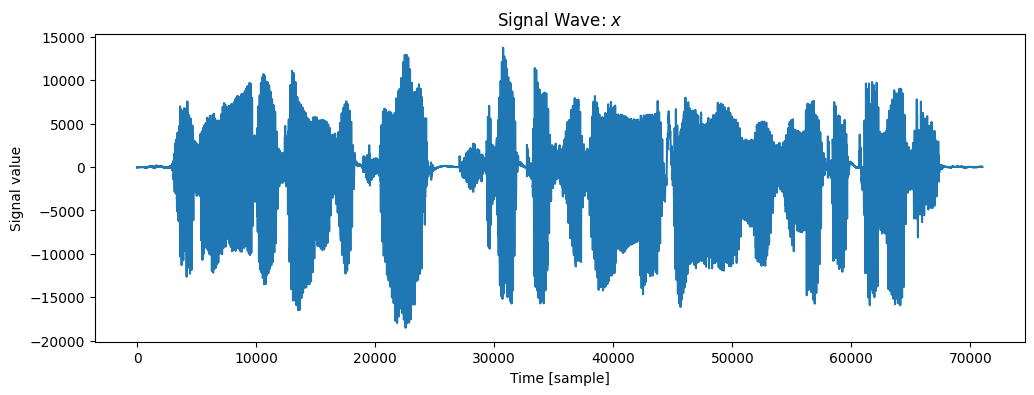

In [19]:
%matplotlib inline
# 音声波形の描画例1 (matplotlibの練習)

# 時間軸の準備
t = np.arange(0, len(x), 1)   # 0, 1, 2, ,,,, len(x)-1
    # - この例では，配列の番号をそのまま与えるようにしている．
    # - ここを変えることで，描画後の図面における横軸（時間軸）の，単位に関する解釈が変化する．
    # 【重要】
    # - 単位が変わるなら，当然，描画した図面の横軸ラベルの単位も変える必要がある．

print('Debug: Data x    = {}'.format(x))
print('Debug: Time axis = {}'.format(t))

# 波形表示
fig1, ax1 = plt.subplots(1, 1, figsize=(12, 4), num=1, clear=True)
    # - 引数について：
    #   - 第1引数と第2引数は，描画エリアの数をrowとcolで指定します．
    #     - 例えば，2, 3なら縦に2つ，横に3つです．
    #     - 戻り値の ax は，rowとcolの数に応じて，スカラや配列や二重配列になる点に気を付けてください．
    #       （つまり，ax1.plot()だったり，ax1[0].plot() だったり，ax1[0][0].plot()だったりします．）
    #   - figsize は，図の大きさです．
    #   - num は，図番号です．Jupyter環境ではそれほど与えるメリットはないのですが，
    #     一般的な .py スクリプトであれば，描く先という意味で重要な意味を持ちます．
    #   - clear=True は，すでに図があるなら消すオプションです．num を与えるなら，明示的に
    #     指定したほうが無難です．（デフォルトは False）
    #
    # [以下，やや蛇足]
    #   - %matplotlib widgetでは clear=True が必須です．つけないとどんどん上描きされます．

ax1.plot(t, x)
    # 【重要】
    # - tとxを同時に与えることで，tの値に沿ってxを描くことができる．
    # - 散布図において，各点を線で結んだような図になる．
    #   - 参考：スライド #4
    # - わかりにくいという人は，
    #     plt.plot( np.array([1, 2, 3]), np.array([4, 5, 6]) , 'o-')
    #   や
    #     plt.plot( np.array([1, 4, 9]), np.array([4, 5, 6]) , 'o-')
    #   を，Consoleで実行し，描かれた図を確認してみよう．

ax1.set_title("Signal Wave: $x$")   # 図の上部にタイトルを追加する
ax1.set_xlabel("Time [sample]")     # 図の下に横軸のラベルを追加する
ax1.set_ylabel('Signal value')      # 図の左に縦軸のラベルを追加する

plt.show()
    # figure()で準備，plotとtitle等で描画，最後に show で表示，という流れです．

# 参考：音波形を表示するときは，近くに再生用のUIも出しておくと便利．
display(Audio(x, rate=sampling_rate))

:::{important} PRACTICE &star;

ここまでの内容を確認するため，まとめとして，次のような動作をするプログラムを，以下のセルに書いてみましょう．

- 音声ファイルから，音データと必要なメタ情報のみを取得する
  - 音声ファイルのファイル名は `filename` 変数に格納されているものとする．
- 取得した音データとメタ情報を利用して，時間波形プロットを描く
- 時間波形プロットでは，**横軸（時間軸）を秒単位に換算**して，描かれているようにする．
  - ヒント1: 適切な配列 `t` を計算して求めればよい．メタ情報のいずれかを使って計算する必要がある．
  - ヒント2: 次の計算を Console で実行し，結果を確認してみよう．
    ```
    print("Hint: [1, 2, 3] / 2 = {}".format(np.array([1, 2, 3]) / 2))
    ```
  - ヒント3: 描く時間波形プロットは，ある種の散布図である．このことは，すでに上記の波形の表示例でも説明している．
- 最後に，描画した図面上の単位に，誤りがないように注意して，軸ラベルを修正する．（初期の実装例の横軸は sample 単位）

:::

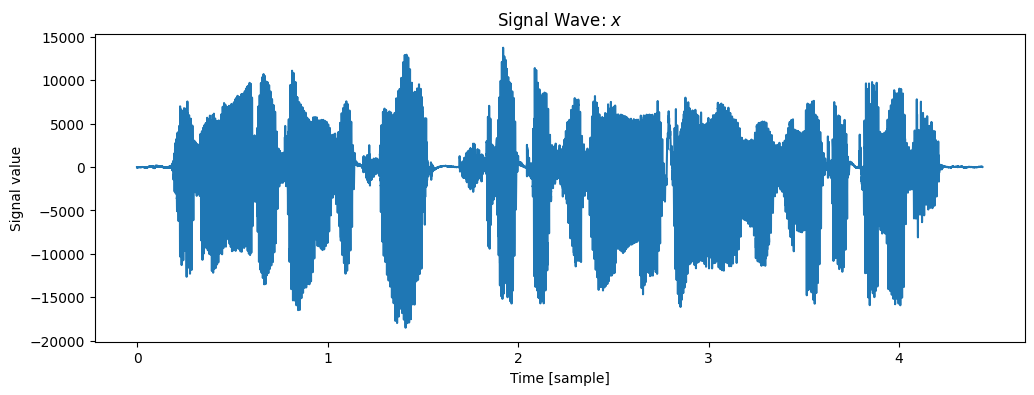

In [4]:
#-------------------------------------------------------------------------------

filename = 'example/a01_v2.wav'
f = wave.open(filename, 'rb')

_x_bytearray = f.readframes(f.getnframes())
x = np.frombuffer(_x_bytearray, dtype=np.int16)

sampling_rate = f.getframerate()
t = np.arange(0, len(x), 1)
t = np.array(t / sampling_rate)

# 波形表示
fig1, ax1 = plt.subplots(1, 1, figsize=(12, 4), num=1, clear=True)
    # - 引数について：
    #   - 第1引数と第2引数は，描画エリアの数をrowとcolで指定します．
    #     - 例えば，2, 3なら縦に2つ，横に3つです．
    #     - 戻り値の ax は，rowとcolの数に応じて，スカラや配列や二重配列になる点に気を付けてください．
    #       （つまり，ax1.plot()だったり，ax1[0].plot() だったり，ax1[0][0].plot()だったりします．）
    #   - figsize は，図の大きさです．
    #   - num は，図番号です．Jupyter環境ではそれほど与えるメリットはないのですが，
    #     一般的な .py スクリプトであれば，描く先という意味で重要な意味を持ちます．
    #   - clear=True は，すでに図があるなら消すオプションです．num を与えるなら，明示的に
    #     指定したほうが無難です．（デフォルトは False）
    #
    # [以下，やや蛇足]
    #   - %matplotlib widgetでは clear=True が必須です．つけないとどんどん上描きされます．

ax1.plot(t, x)
    # 【重要】
    # - tとxを同時に与えることで，tの値に沿ってxを描くことができる．
    # - 散布図において，各点を線で結んだような図になる．
    #   - 参考：スライド #4
    # - わかりにくいという人は，
    #     plt.plot( np.array([1, 2, 3]), np.array([4, 5, 6]) , 'o-')
    #   や
    #     plt.plot( np.array([1, 4, 9]), np.array([4, 5, 6]) , 'o-')
    #   を，Consoleで実行し，描かれた図を確認してみよう．

ax1.set_title("Signal Wave: $x$")   # 図の上部にタイトルを追加する
ax1.set_xlabel("Time [sample]")     # 図の下に横軸のラベルを追加する
ax1.set_ylabel('Signal value')      # 図の左に縦軸のラベルを追加する

plt.show()
# 参考：音波形を表示するときは，近くに再生用のUIも出しておくと便利．
display(Audio(x, rate=sampling_rate))

f.close()

## SP-0 のまとめ

:::{attention}
SP-0 の必須課題はここまでです．期限までに，Moodleにて提出してください．
:::

(sp-0_appendix)=

## Appendix (付録)

:::{attention}
Appendix は必須課題ではありません．
:::

設定として `%matplotlib widget` を指定すると，理解をより深められる図を描けます．  
時間があればやってみてください．

なお，プログラムそのものは高度で講義の範囲を超えています．図そのものから，「データを描く」という意味の理解を深める程度にしてください．

:::{important}
`%matplotlib widget` は，セルだけに指示を出すものではなく，カーネル（裏で走っている python プロセス）に対して指示を出します．  
つまり，この指示を出した後は，他のセルで plot をする際にも影響を及ぼしてしまいます．  
少し動作が不安定になることもあります．元の描画系に戻すなら `%matplotlib inline` を指定してください．
:::

### Appendix A (Figure 2)

:::{attention}
Appendix は必須課題ではありません．
:::

widget として描画すると，描いた図を後から拡大縮小できます．

描画後，マウスホバーすると現れる <i class="center fa fa-fw fa-arrows"></i> のアイコンをクリックしてください(有効状態になります)．
  - 図の上でマウスの右ボタンを押しながら，左右に動かすと，時間方向の拡大縮小ができます．
  - 図の上でマウスの左ボタンを押しながら，左右に動かすと，時間方向の範囲移動ができます．
  - <i class="center fa fa-fw fa-home"></i> アイコンで元に戻ります．

また，draw_line や draw_marker という文字の横のチェックボックスを使って，線の描画の有無，点の描画の有無を切り替えられます．

波形がどのように描かれているのか，塗りつぶして見えるものは，本来は何を描こうとしているのか，といったことを体験的に理解してみてください[^scatter]．

[^scatter]: すでに Practice の中で，何を描いているのか？という話はしています．棒グラフ？折れ線グラフ？それとも・・・？

In [ ]:
%matplotlib widget
from ipywidgets import interact

fig2, ax2 = plt.subplots(1, 1, figsize=(10, 3), num=2, clear=True)

_art, = ax2.plot(x, '.', color='green', markerfacecolor='orange', markeredgecolor='none')
ax2.set_xlabel('Time [sample]')
ax2.set_ylabel('Signal value')
# 上記で適切な配列 t を計算できているなら，横軸の単位を秒にして描画してみるのも良いでしょう．

ax2.grid(True)
ax2.set_ylim([-20000, 20000])

def modify_waveform_param(draw_line, draw_marker):
    _art.set(linestyle='-' if draw_line else '')
    _art.set(marker='.' if draw_marker else '')

interact(modify_waveform_param, draw_line=False, draw_marker=True)

plt.show()

### Appendix B (Figrue 3)

:::{attention}
Appendix は必須課題ではありません．
:::

以下は，拡大箇所をインタラクティブに指定できる例です．

上側の図は，波形の全体図を描画し，xposで指定した個所から width の大きさの範囲を赤背景で塗っています．  
下側の図は，その範囲を拡大して描画しています．

実際に拡大範囲をいろいろに変えてみて，波形を描くということを正しく理解してください．

波形を描く＝うまいこと塗りつぶす，のような理解をしている人は，もう一度考え直してください．（画像実験に入ってからのほうがわかりやすいかもしれませんが・・・）

In [ ]:
%matplotlib widget
from ipywidgets import interact, IntSlider, FloatLogSlider

fig3, ax3 = plt.subplots(2, 1, figsize=(10, 4), num=3, clear=True)

_artists = {}
ax3[0].set_xlim([0, len(x)])
ax3[0].set_ylim([-20000, 20000])
ax3[1].set_xlabel('Time [sample]')
_artists['plt0'] = ax3[0].plot(x, '-')
_artists['plt1'] = ax3[1].plot(x, 'o-', color='#99fc', markerfacecolor='#33f', )

def plot_waveforms(xpos: int, width: int):
    n = np.arange(xpos, xpos+width)

    if width >= 200:
        _artists['plt1'][0].set(marker='')
    elif width >= 50:
        _artists['plt1'][0].set(marker='.')
    else:
        _artists['plt1'][0].set(marker='o')

    if 'box_red' in _artists:
        _artists['box_red'].remove()
    _artists['box_red'] = ax3[0].axvspan(n[0], n[-1], color="#f993")

    ax3[1].set_xlim([xpos, xpos+width])

interact(plot_waveforms,
         xpos=IntSlider(value=12000, min=0, max=70000, step=100),
         width=FloatLogSlider(value=1000, base=10, min=1, max=4.6, step=0.2))
plt.show()


### Appendix C (Figure 4)

:::{attention}
Appendix は必須課題ではありません．
:::

最後に，画像実験にもつながるような図を描いておきます．

ここまでの図は，ある時刻(x軸)における信号の強さ(y軸)として描いていました．  
（以下の図の下側の図）

以下で示される図の上側は，ある時刻(x軸)における信号の強さを色（濃淡）として表しています[^yaxis]．  
一部の時刻を拡大して表示していますが，これもマウスでいろいろ操作して，確認してみてください．

[^yaxis]: 今回の白黒の絵については，y軸方向に特に意味はありません．本来縦方向には 1 ドットしかない図を，縦方向にギューッと伸ばして描画しています．



In [ ]:
%matplotlib widget

fig4, ax4 = plt.subplots(2, 1, figsize=(10, 3), sharex=True,
                         num=4, clear=True)

_ = ax4[0].imshow(x.reshape(1,-1), aspect='auto', cmap='binary', interpolation=None)
ax4[0].set_yticks([])
fig4.colorbar(_, ax=ax4, extend='max', label='Signal value')

ax4[1].plot(x)
ax4[1].set_xlabel('Time [sample]')
ax4[1].set_xlim([12000, 13000])

plt.show(ax4)

:::{exercise}
Appendix A と Appendox B の内容も踏まえて，
「信号の時間波形を図として描く」ために必要な考えと，「図を適切な領域に収めて描く」ために必要な考えを切り分けて，  
図として描かれた信号の時間波形について，自分の言葉での説明を試みてください．

```{attention}
これは，Appendix の中の exercise であり，必須ではありません．

特に後者の考えを実現する方法については，画像実験の範疇なので，そちらの実験課題を通して学び取ってください．  
ここでは，何が必要か，ということを理解するにとどめておけば十分です．
```

:::

### Appendix のまとめ

Appendix は以上です．